In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import random
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir='/content/drive/My Drive/Shop DataSet'
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    fpath=os.path.join(data_dir,fold)
    fpaths=os.listdir(fpath)
    for f in fpaths:
        fpa=os.path.join(fpath,f)
        filepath.append(fpa)
        labels.append(fold)
fseries=pd.Series(filepath,name='video_name')
lseries=pd.Series(labels,name='labels')
df=pd.concat([fseries,lseries],axis=1)
df

,video_name,labels
0,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
1,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
2,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
3,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
4,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
...,...,...
850,/content/drive/My Drive/Shop DataSet/non shop ...,non shop lifters
851,/content/drive/My Drive/Shop DataSet/non shop ...,non shop lifters
852,/content/drive/My Drive/Shop DataSet/non shop ...,non shop lifters
853,/content/drive/My Drive/Shop DataSet/non shop ...,non shop lifters


In [ ]:
df['labels'].value_counts()

,count
labels,
non shop lifters,531
shop lifters,324


In [ ]:
train_df,dummy_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df['labels'])
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=dummy_df['labels'])
train_df.shape,valid_df.shape,test_df.shape

((684, 2), (85, 2), (86, 2))

In [ ]:
class VideoDataGenerator(Sequence):
    def __init__(self, df, batch_size, img_size, frame_count, shuffle=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.frame_count = frame_count
        self.shuffle = shuffle
        self.augment = augment

        # Convert categorical labels to integers
        self.label_encoder = LabelEncoder()
        self.df['labels'] = self.label_encoder.fit_transform(self.df['labels'])  # Encode labels as integers
        self.num_classes = len(self.label_encoder.classes_)

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_data):
        X = []
        y = []
        for _, row in batch_data.iterrows():
            cap = cv2.VideoCapture(row['video_name'])
            frames = []
            for _ in range(self.frame_count):
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, self.img_size)
                if self.augment:
                    if random.random() > 0.5:
                        frame = cv2.flip(frame, 1)  # Random horizontal flip
                    angle = random.randint(-10, 10)
                    M = cv2.getRotationMatrix2D((self.img_size[0]//2, self.img_size[1]//2), angle, 1)
                    frame = cv2.warpAffine(frame, M, self.img_size)
                frames.append(frame / 255.0)
            cap.release()

            while len(frames) < self.frame_count:
                frames.append(np.zeros((self.img_size[0], self.img_size[1], 3)))

            X.append(np.array(frames))
            y.append(row['labels'])

        return np.array(X), to_categorical(np.array(y), num_classes=self.num_classes)


In [ ]:
BATCH_SIZE = 4
IMG_SIZE = (64, 64)
FRAME_COUNT = 20

train_gen = VideoDataGenerator(train_df, BATCH_SIZE, IMG_SIZE, FRAME_COUNT, shuffle=True, augment=True)
val_gen = VideoDataGenerator(valid_df, BATCH_SIZE, IMG_SIZE, FRAME_COUNT, shuffle=False, augment=False)
test_gen = VideoDataGenerator(test_df, BATCH_SIZE, IMG_SIZE, FRAME_COUNT, shuffle=False, augment=False)

num_classes = train_gen.num_classes

In [ ]:
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(FRAME_COUNT, IMG_SIZE[0], IMG_SIZE[1], 3)),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),

    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_54                  │ (None, 20, 64, 64, 32)      │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_55                  │ (None, 20, 32, 32, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_56                  │ (None, 20, 32, 32, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_57                  │ (None, 20, 16, 16, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_58                  │ (None, 20, 16384)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │       4,210,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,234,626 (16.15 MB)

 Trainable params: 4,234,626 (16.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(train_gen,epochs=15,validation_data=val_gen)

Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 52s 184ms/step - accuracy: 0.5963 - loss: 0.7093 - val_accuracy: 0.6190 - val_loss: 0.6641
Epoch 2/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.6151 - loss: 0.6643 - val_accuracy: 0.6190 - val_loss: 0.6712
Epoch 3/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.6261 - loss: 0.6660 - val_accuracy: 0.6190 - val_loss: 0.6342
Epoch 4/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.6473 - loss: 0.6242 - val_accuracy: 0.3810 - val_loss: 1.1530
Epoch 5/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.7860 - loss: 0.4645 - val_accuracy: 0.9167 - val_loss: 0.2620
Epoch 6/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.8460 - loss: 0.3616 - val_accuracy: 0.9405 - val_loss: 0.1861
Epoch 7/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 31s 179ms/step - accuracy: 0.9145 - loss: 0.2321 - val_accuracy: 0.9286 - val_loss: 0.3350
Epoch 8/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.9480 - loss: 0

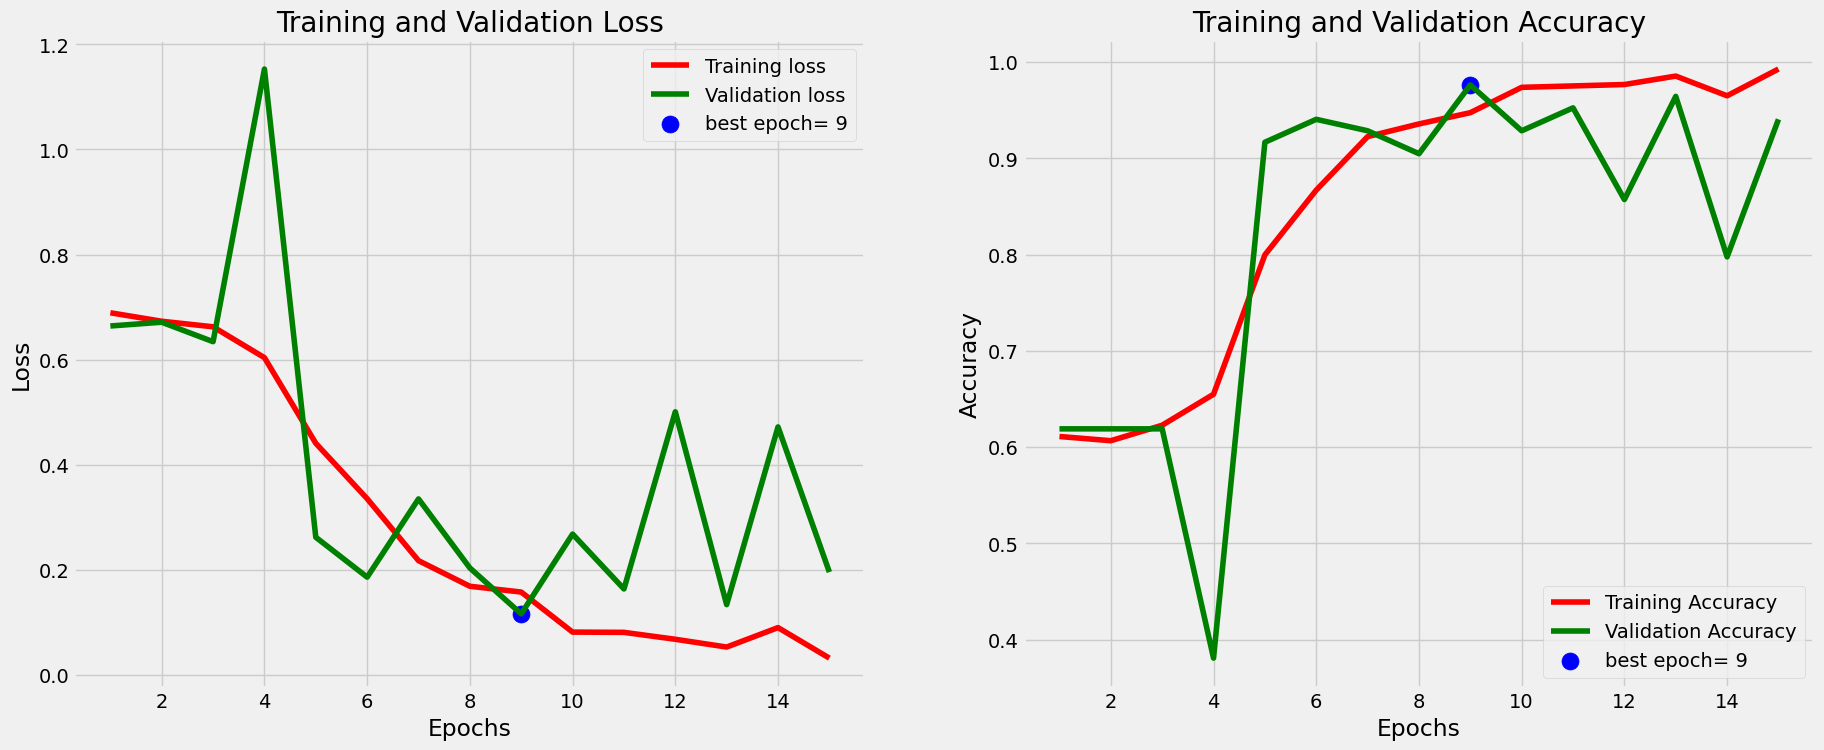

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(val_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0013
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 1.0000 - loss: 0.0017
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 1.0000 - loss: 9.5132e-04
Train Loss:  0.0011580025311559439
Train Accuracy:  1.0
--------------------
Valid Loss:  0.0014376712497323751
Valid Accuracy:  1.0
--------------------
Test Loss:  0.0012026324402540922
Test Accuracy:  1.0


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


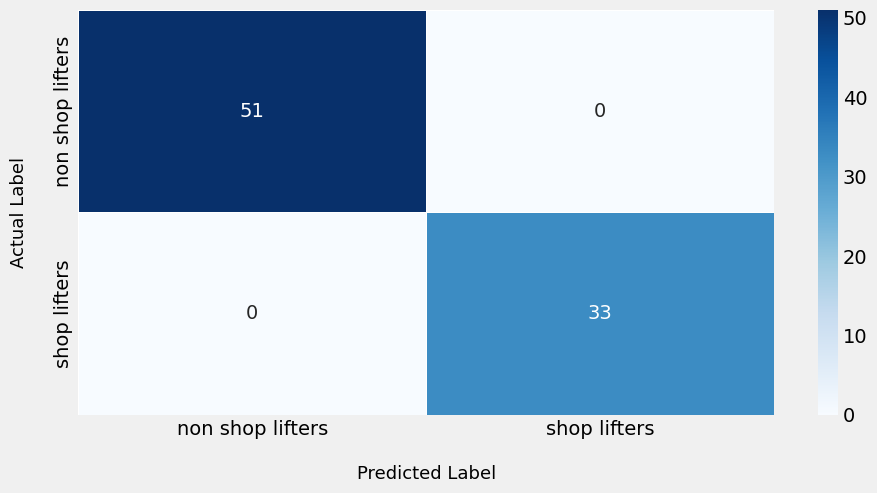

In [ ]:
# Get predictions for the entire test set using a loop
y_pred_all = []
y_true_all = []  # Initialize list to store true labels

for i in range(len(test_gen)):
    x, y_true = test_gen[i]  # Get a batch of data and true labels
    preds = model.predict(x)  # Predict for the batch
    y_pred_all.extend(np.argmax(preds, axis=1))  # Add batch predictions to the list
    y_true_all.extend(np.argmax(y_true, axis=1))  # Add batch true labels to the list

# Convert to NumPy array
y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)  # Convert true labels to NumPy array

# Now use y_pred_all and y_true_all in your confusion matrix
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_true_all, y_pred_all)  # Use y_true_all instead of test_gen.df['labels']
labels = list(test_gen.label_encoder.classes_)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label', fontsize=13)
plt.ylabel('Actual Label\n', fontsize=13)
plt.show()

In [ ]:
print(classification_report(y_true_all, y_pred_all, target_names=test_gen.label_encoder.classes_))

                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00        51
    shop lifters       1.00      1.00      1.00        33

        accuracy                           1.00        84
       macro avg       1.00      1.00      1.00        84
    weighted avg       1.00      1.00      1.00        84



In [ ]:
model.save('video_classification.h5')